### ROC-AUC

In [26]:
from src.cbr_trainer.query_dataloader import DataLoader
from src.cbr_trainer.rgcn_model import HeteroRGCN
from src.cbr_trainer.rgcn_model import HeteroRGCNLayer
from src.important_paths.explainer import MaskExplainer
from src.cbr_trainer.utils.dist_scr import L2Dist
from collections import *

import pandas as pd
import os
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import dgl
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:

data_dir = "data/MIND/"
data_name = "MIND"
paths_file_dir = "MIND_cbr_subgraph_knn-15_branch-1000.pkl"
device =  "cuda"

In [3]:
# Initialize data loader
dataset_obj = DataLoader(data_dir, 
                         data_name, 
                         paths_file_dir)

05/01/2025 11:34:12 - INFO - root - Loading and processing graph data...
05/01/2025 11:34:41 - INFO - root - Creating node mappings...
05/01/2025 11:34:41 - INFO - root - Loading paths data...
05/01/2025 11:34:44 - INFO - root - Processing CSV data...
05/01/2025 11:34:44 - INFO - root - Processing path data...
100%|█████████| 878/878 [00:01<00:00, 792.15it/s]
05/01/2025 11:34:48 - INFO - root - Building node labels...
05/01/2025 11:34:48 - INFO - root - Building train dataset...
100%|██████████| 760/760 [07:13<00:00,  1.75it/s]
05/01/2025 11:42:01 - INFO - root - Building test dataset...
100%|██████████| 243/243 [02:50<00:00,  1.42it/s]
05/01/2025 11:44:52 - INFO - root - Building dev dataset...
100%|██████████| 116/116 [01:12<00:00,  1.60it/s]


In [4]:
model_path = 'link_prediction_results/MIND/model/'
model_name = 'best_model_MIND_021624.pth'

model_dir = os.path.join(model_path, model_name)


In [ ]:
model = torch.load(model_dir, map_location=device)
model.to(device)
model.eval()

In [6]:
from types import SimpleNamespace
args_dict = {
"lr_" :0.1,
"num_epochs": 10,
"penalty" : 1.0,
"degree_thr" :10,
"split": "test",
"alpha": 1.0,
"beta": 1.0}
args = SimpleNamespace(**args_dict)


In [7]:
nodes_mapping = dataset_obj.nodes_mapping
if args.split == "test":
        drug_dis_train = [(item["seed_entities"][0], ans) for item in dataset_obj.raw_test_data for ans in item["answer"]]
    

In [8]:
# Initialize explainer
explainer = MaskExplainer(model, device, args, args.split)

In [9]:
#Load true indications from DMDB

dmdb_paths= pd.read_pickle("data/DMDB_ground-truth_paths.pkl")
                           
dmdb_pairs = set()
for drug_id,dis_id in zip(dmdb_paths["mrn_drug"], dmdb_paths["mrn_dis"]):
    dmdb_pairs.add((drug_id,dis_id ))

Calculate ROC-AUC

In [13]:
mrn_nodes = pd.DataFrame(dataset_obj.node_labels.items(), columns=['id', 'label']) 

In [15]:
def get_homid (graph, id_, ntype_hetero_nids_to_homo_nids):
    """
    Get hom for a given node
    """

    label = mrn_nodes[mrn_nodes['id'] == id_]['label'].iloc[0]
    global_index = nodes_mapping[label][0][id_]
    local_index = np.where(graph.nodes[label][0]["_ID"].cpu().numpy() == global_index)[0].item()

    homogeneous_index =  ntype_hetero_nids_to_homo_nids[(label, local_index)]
    
    return homogeneous_index

In [18]:
auc_results = defaultdict(list)
all_true_mask = []
all_pred_mask =  []

In [ ]:
for drug_id, dis_id in tqdm(dmdb_pairs):
    try:
        orig_pred, ml_ghomo, ml_eweight_dict, ml_ghomo_eweights, ntype_hetero_nids_to_homo_nids, nn_graph, nn_idx, paths = explainer.explain(drug_id, 
                                                                                                       dis_id, 
                                                                                                       dataset_obj, 
                                                                                                        True, 
                                                                                                        args.split)
    
    
    except:
        continue
    nn_graph[0].edata['eweight'] = ml_eweight_dict
    # convert ghetero to ghomo and find paths
    ghomo = dgl.to_homogeneous( nn_graph[0], edata=['eweight'])
    
    
    
    pred_mask = ghomo.edata["eweight"].tolist()
    all_pred_mask.append(pred_mask)
    
    
    #DMDB true paths
    dmdb_paths_query= dmdb_paths.query("mrn_drug == @drug_id & mrn_dis == @dis_id")['path_mrn'].to_list()

    #extract true paths as edges 
    dmdb_edges_query = []
    for input_list in dmdb_paths_query:
        for edge in [(input_list[i], input_list[i + 1]) for i in range(len(input_list) - 1)]: 
            dmdb_edges_query.append(edge)
            
    
    
    
    u,v = ml_ghomo.edges()
    true_id_edge = []
    for edge in dmdb_edges_query: 
        # print(edge)
        src_id,tgt_id = edge[0], edge[1]
    
        homo_src, homo_tgt = get_homid (nn_graph[0],src_id, ntype_hetero_nids_to_homo_nids), get_homid (nn_graph[0], tgt_id, ntype_hetero_nids_to_homo_nids) #homo identifier
        
        #get mask index for (homo_src,homo_tgt) edge
        src_edges = np.where(u.cpu().numpy() == homo_src)
        tgt_edges = np.where(v.cpu().numpy() == homo_tgt)
    
    
        for i in np.intersect1d(src_edges, tgt_edges).tolist(): 
            # print(pred_mask[i])
            true_id_edge.append(i)
            
    true_mask = np.zeros(len(ghomo.edata["eweight"].tolist()))
    true_mask[true_id_edge]=1
    
    all_true_mask.append(true_mask)

    fpr, tpr, thresholds = metrics.roc_curve(true_mask, ghomo.edata["eweight"].tolist(), pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save
    auc_results[(drug_id, dis_id)].append(roc_auc)
    print("AUC mean: ", np.mean([i[0] for i in auc_results.values() if i[0] != "None"]))
    

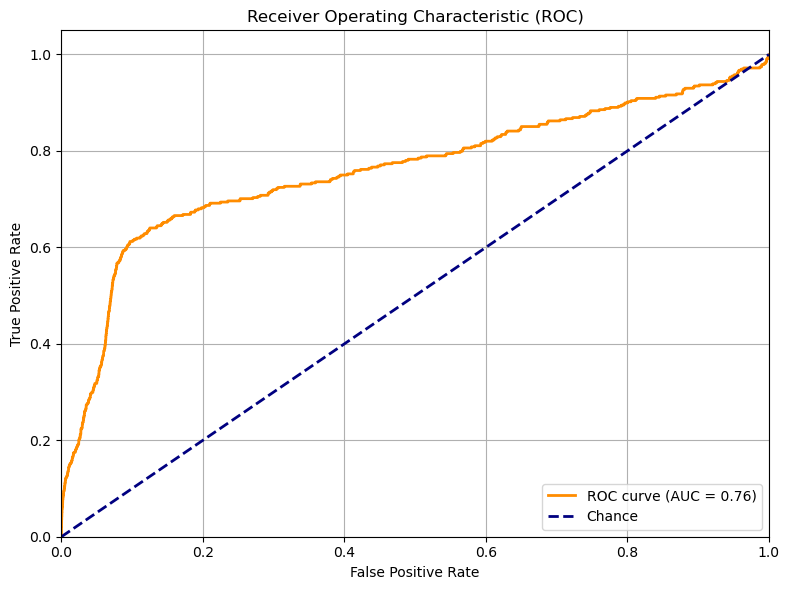

In [30]:
#Concatenate results for all queries 
all_true_mask_conct = np.concatenate(all_true_mask, axis=0, out=None)
all_pred_mask_conct = np.concatenate(all_pred_mask, axis=0, out=None)
fpr, tpr, thresholds = metrics.roc_curve(all_true_mask_conct, all_pred_mask_conct, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc


# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()